Link to current Kaggle dataset: https://www.kaggle.com/datasets/enesbayturk/vehicle-and-pedestrian-detection-dataset

8 classes, images of big truck, small truck, bus, car, motorcycle, van, and pedestrian. 

In [1]:
import sys
import os

import datetime
import copy

import numpy as np
import sklearn

import scipy as sp
import pandas as pd

import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset

from torch.nn import Flatten, Linear, Conv2d, MaxPool2d, Dropout, Sequential
from torch.nn import ReLU, Sigmoid, Softmax

In [2]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), # Data augmentation - horizontal flip, rotation, color properties
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((128, 128)),  # Resize all images to the same size
    transforms.ToTensor(),
])

regular_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load images, resize all to 128x128 pixels, save as tensors
dataset_unaug = datasets.ImageFolder(root='vehicles/Veri Seti', transform = regular_transform)
dataset_aug = datasets.ImageFolder(root='vehicles/Veri Seti', transform=aug_transform)

# Split Data into training and valtest
# Dont split augmented dataset, bc all of that will be for training
n_train = len(dataset_unaug) * 0.5
n_train = int(n_train)
n_valtest = len(dataset_unaug) - n_train
train_set, valtest = random_split(dataset_unaug, [n_train, n_valtest])

# Now split valtest again to get validation and test sets
n_val = len(valtest) // 2
n_test = len(valtest) - n_val
validation_set, test_set = random_split(valtest, [n_val, n_test])


# Only use data augmentation on the training set to avoid data leakage

# Now append the augmented dataset to train_set
train_combined_set = ConcatDataset([train_set, dataset_aug])
print(len(train_combined_set))
print(len(validation_set))
print(len(test_set))

# Create DataLoaders for each
batch = 32
train_loader = DataLoader(train_set, batch_size=batch, shuffle=True)
val_loader = DataLoader(validation_set, batch_size=batch, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch, shuffle=False)

8622
1437
1437


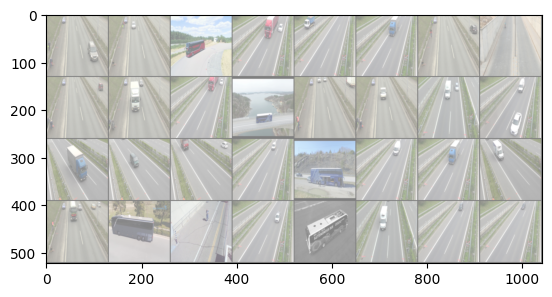

In [3]:
from matplotlib import pyplot as plt
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, classes = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=False)

In [ ]:

# class CNN(nn.Module):
#         def __init__(self):
#             super(CNN, self).__init__()
#             self.conv1 = nn.Conv2d(1, 6, 5) # Conv2d(1, 6, 5) -> (input has 1 channel because grayscale, 6 filters as output, the filter_size is (5,5))
#             self.pool = nn.MaxPool2d(2, 2) 
#             self.conv2 = nn.Conv2d(6, 64, 3)
#             self.conv3 = nn.Conv2d(64, 128, 2)
#             # note: we will pool again here, but since same pooling function used, don't redefine, just clarify this order in forward func (this is what will actually happen when model is trained)
#             self.fc1 = nn.Linear(128 * 2 * 2, 150) #fully connected layers
#             self.fc2 = nn.Linear(150, 84)
#             self.fc3 = nn.Linear(84, 8) # because 8 classes in kaggle dataset

#         def forward(self, x):
#             x = self.pool(F.relu(self.conv1(x))) 
#             x = self.pool(F.relu(self.conv2(x))) # can print shape of x, to debug and see what expected input/output sizes are
#             x = self.pool(F.relu(self.conv3(x)))
#             x = x.view(-1, 128*2*2)   # returns a "view" (reshape) of the tensor without copying (in this case we flatten)
#             x = F.relu(self.fc1(x))
#             x = F.relu(self.fc2(x))
#             x = self.fc3(x)
#             return x
        
# model = CNN()


# opt = optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()
# model.optimizer = opt
# model.loss_func = nn.CrossEntropyLoss()

In [11]:
#Basic CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.model = nn.Sequential(
            Conv2d(3, 32, kernel_size=3, padding=1),  # Input channels: 3 (RGB), Output: 32
            ReLU(),
            MaxPool2d(2, 2),

            Conv2d(32, 64, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2, 2),

            Conv2d(64, 128, kernel_size=3, padding=1),
            ReLU(),
            MaxPool2d(2, 2),

            Flatten(),

            Linear(128 * 16 * 16, 512),  # Image size is 128x128 → pooled 3 times → 16x16
            ReLU(),
            Dropout(0.3),

            Linear(512, num_classes)
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # model.to(device)

CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
  (loss_func): CrossEntropyLoss()
)

In [12]:
# Instantiate model
num_classes = len(dataset_unaug.classes)
model = SimpleCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         correct = 0
#         total = 0

#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         train_loss = running_loss / total
#         train_acc = correct / total
# train_model(model, train_loader, val_loader, criterion, opt, num_epochs=10)

RuntimeError: Given groups=1, weight of size [6, 1, 5, 5], expected input[32, 3, 128, 128] to have 1 channels, but got 3 channels instead

In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = model(val_images)
                _, val_preds = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_preds == val_labels).sum().item()

        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10, Train Loss: 0.5199, Train Acc: 0.7951, Val Acc: 0.8386
Epoch 2/10, Train Loss: 0.3250, Train Acc: 0.8772, Val Acc: 0.8977
Epoch 3/10, Train Loss: 0.1911, Train Acc: 0.9262, Val Acc: 0.9367
Epoch 4/10, Train Loss: 0.1428, Train Acc: 0.9478, Val Acc: 0.9367
Epoch 5/10, Train Loss: 0.1300, Train Acc: 0.9502, Val Acc: 0.9374
Epoch 6/10, Train Loss: 0.1423, Train Acc: 0.9506, Val Acc: 0.9555
Epoch 7/10, Train Loss: 0.0527, Train Acc: 0.9791, Val Acc: 0.9318
Epoch 8/10, Train Loss: 0.0669, Train Acc: 0.9739, Val Acc: 0.9499
Epoch 9/10, Train Loss: 0.0535, Train Acc: 0.9812, Val Acc: 0.9687
Epoch 10/10, Train Loss: 0.0368, Train Acc: 0.9878, Val Acc: 0.9756


Test Accuracy: 0.9743
Test Precision (weighted): 0.9760
Test Recall (weighted): 0.9743
Test F1 Score (weighted): 0.9742


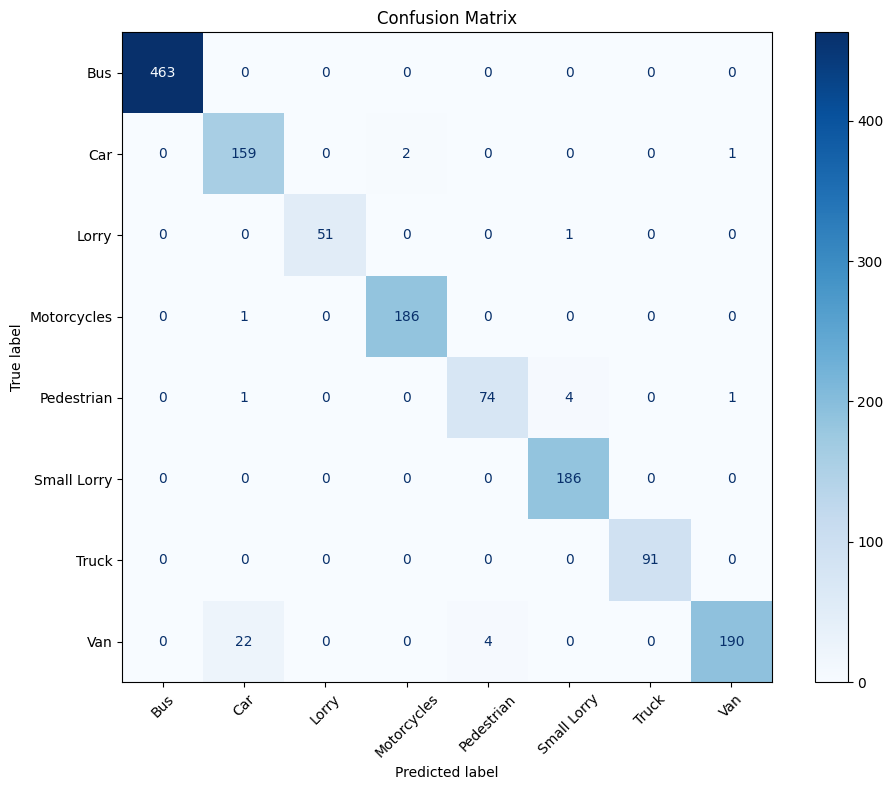

In [15]:
# Model evaluation for basic cnn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


true_labels, pred_labels = evaluate_model(model, test_loader)

accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision (weighted): {precision:.4f}")
print(f"Test Recall (weighted): {recall:.4f}")
print(f"Test F1 Score (weighted): {f1:.4f}")


import matplotlib.pyplot as plt

class_names = dataset_unaug.classes

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
